In [1]:
from tensorly.metrics.regression import RMSE
import time
import scipy.io
import tensorly as tl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorly.cp_tensor import CPTensor
from nn_parafac_normalization_comparison import *
import musicntd.model.features as features
import musicntd.data_manipulation as dm
import musicntd.tensor_factory as tf
import soundfile as sf
np.set_printoptions(precision=3)

#audio
data,sampling_rate = sf.read('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

#Parameters
rank=5
init='random'
hop_length = 512
n_fft = hop_length * 4
hop_length_seconds = hop_length/sampling_rate


stft_spec = features.get_spectrogram(data[:,0], sampling_rate, 
                                     feature="stft", n_fft = n_fft, hop_length = hop_length)
bars = dm.get_bars_from_audio('/home/ctuna/tensoptly/benchmark_data/Audio/The Beatles - Come Together.wav')

tensor = tf.tensorize_barwise(stft_spec, bars, hop_length_seconds, 40)
normalization_functions=[non_negative_parafac_normalize_1, non_negative_parafac_normalize_2, 
                         non_negative_parafac_normalize_3, 
                         non_negative_parafac_normalize_4]
time_cp = tl.zeros([4, 5])
errors1 = []
weights1 = []
errors2 = []
weights2 = []
rec_errors = tl.zeros([4, 5])

/usr/local/lib64/python3.8/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


hop_length a 44100Hz = 512, normal ?


/usr/local/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


1. Normalization at each outer loop (PR)
2. Normalization at each inner loop iteration (last factor is normalized after error calculation)
3. Normalization at the very end
4. 2 and 3 together

In [2]:
for j in range(5):
  for i in range(4):
     tic = time.time()
     tensornorm, errorsnorm, weights_iter = normalization_functions[i](tensor, rank=rank, init=init, normalize_factors=True, return_errors=True)
     weightsnorm, factorsnorm = tensornorm
     cp_reconstructionnorm = tl.cp_to_tensor((weightsnorm, factorsnorm))
     time_cp[i, j] = time.time()-tic
     rec_errors[i, j] = RMSE(tensor,cp_reconstructionnorm)
     
     if j==4:
        weights1.append(weights_iter)
        errors1.append(errorsnorm)

# Error per iteration 

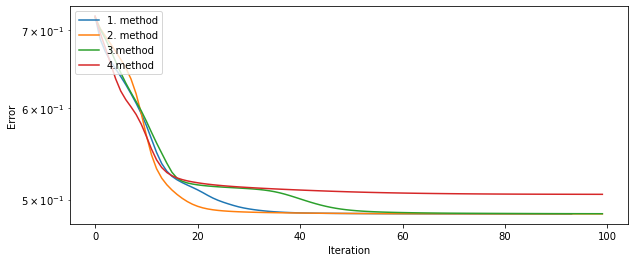

In [3]:
each_iteration(errors1[0], errors1[1], errors1[2], errors1[3])

# Plotting weights per iteration for each method

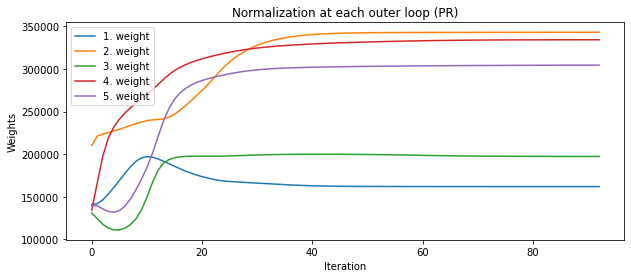

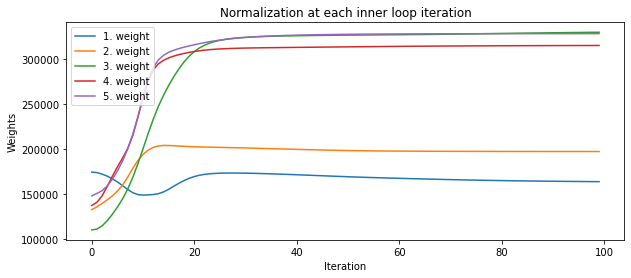

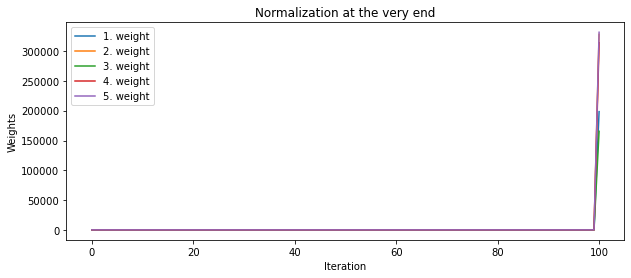

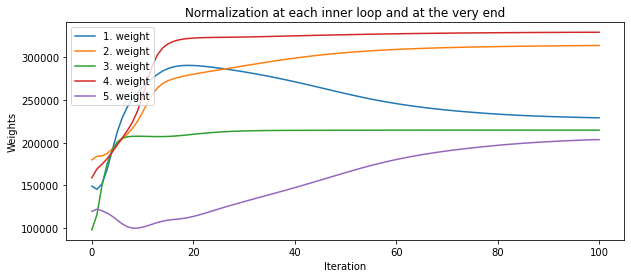

In [4]:
plot_weights(weights1[0], "Normalization at each outer loop (PR)")
plot_weights(weights1[1], "Normalization at each inner loop iteration")
plot_weights(weights1[2], "Normalization at the very end")
plot_weights(weights1[3], "Normalization at each inner loop and at the very end")

# Last weights

In [5]:
print("1. Method:"+ str(weights1[0][-1]))
print("2. Method:"+ str(weights1[1][-1]))
print("3. Method:"+ str(weights1[2][-1]))
print("4. Method:"+ str(weights1[3][-1]))

1. Method:[161921.53 343211.5  197309.78 334378.03 304633.66]
2. Method:[163840.55 197377.1  330186.9  315449.   328649.53]
3. Method:[198366.1  327649.3  165443.3  313698.56 331281.25]
4. Method:[229125.42 313476.8  214599.16 328988.06 203521.62]


# Mean and standard deviation of reconstruction error

In [6]:
print("1. Method:"+ ' ' + str("%.3f" % tl.mean(rec_errors[0, :]))+ ' ' + str("%.3f" % np.std(rec_errors[0, :])))
print("2. Method:"+ ' ' + str("%.3f" % tl.mean(rec_errors[1, :]))+ ' ' + str("%.3f" % np.std(rec_errors[1, :])))                     
print("3. Method:"+ ' ' + str("%.3f" % tl.mean(rec_errors[2, :]))+ ' ' + str("%.3f" % np.std(rec_errors[2, :])))                     
print("4. Method:"+ ' ' + str("%.3f" % tl.mean(rec_errors[3, :]))+ ' ' + str("%.3f" % np.std(rec_errors[3, :])))               

1. Method: 196.970 4.289
2. Method: 194.948 3.745
3. Method: 194.199 4.605
4. Method: 199.437 0.062


# Mean and standard deviation of processing time

In [7]:
print("1. Method:"+ ' ' + str("%.3f" % tl.mean(time_cp[0, :]))+ ' ' + str("%.3f" % np.std(time_cp[0, :])))
print("2. Method:"+ ' ' + str("%.3f" % tl.mean(time_cp[1, :]))+ ' ' + str("%.3f" % np.std(time_cp[1, :])))                     
print("3. Method:"+ ' ' + str("%.3f" % tl.mean(time_cp[2, :]))+ ' ' + str("%.3f" % np.std(time_cp[2, :])))                     
print("4. Method:"+ ' ' + str("%.3f" % tl.mean(time_cp[3, :]))+ ' ' + str("%.3f" % np.std(time_cp[3, :])))       

1. Method: 4.078 0.267
2. Method: 3.690 0.361
3. Method: 3.900 0.309
4. Method: 3.755 0.340
